In [1]:
import datetime as dt
import os
import random
import re

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook+plotly_mimetype"
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.__version__

'1.0.0'

In [16]:
# Create dataframe from pickle file
charts = pd.read_pickle(os.path.join('data', 'alltime_top_100'))

## Data Handling and Feature Engineering

In [17]:
# Delete duplicates
charts.drop_duplicates(keep='first',inplace=True)

In [18]:
# Convert start_date and end_date to datetime objects
charts['start_date']= pd.to_datetime(charts['start_date'], format='%d.%m.%Y')
charts['end_date']= pd.to_datetime(charts['end_date'], format='%d.%m.%Y')

In [19]:
# Convert position into dtype int
charts['position'] = charts['position'].astype(int)

In [20]:
# Add column week
charts['week'] = charts['start_date'].dt.week

In [21]:
# Add column year
charts['year'] = charts['start_date'].dt.year

In [22]:
# Add column decade
charts.loc[charts['year'] < 2020, 'decade'] = '2010s'
charts.loc[charts['year'] < 2010, 'decade'] = '2000s'
charts.loc[charts['year'] < 2000, 'decade'] = '1990s'
charts.loc[charts['year'] < 1990, 'decade'] = '1980s'
charts.loc[charts['year'] < 1980, 'decade'] = '1970s'

In [23]:
# Add combination of artist and song (easier for plotting purposes later)
charts['artist_song'] = charts['artist'] + ' - ' + charts['song']

In [24]:
# Determine primary and feature artist
charts['primary_artist'] = charts.loc[:, 'artist'].str.split(r" feat. | feat | x | & ", expand=True)[0]
charts['feature_artist'] = charts.loc[:, 'artist'].str.split(r" feat. | feat | x | & ", expand=True)[1]

In [25]:
# Add column with alltime and yearly peak position of the song
charts['alltime_peak'] = charts.groupby(['artist_song'])['position'].transform('min')
charts['yearly_peak'] = charts.groupby(['year', 'artist_song'])['position'].transform('min')

In [26]:
# Add column to mark if a song was ever in the top10
charts.loc[charts['alltime_peak'] <= 10, 'top10'] = 1
charts.loc[charts['alltime_peak'] > 10, 'top10'] = 0

In [136]:
# Add column with alltime and yearly weeks in charts
charts['weeks_in_charts'] = charts.groupby(['artist_song'])['position'].transform('count')
charts['weeks_in_year'] = charts.groupby(['year', 'artist_song'])['position'].transform('count')

In [137]:
charts.sample(10)

artist  \
174056                                      Tommy Steiner   
141739                                     Paul McCartney   
68292                                      Gavin Rossdale   
98334                                      Culcha Candela   
201499                                       Jason Derulo   
73673                                           Deichkind   
23005   Major Lazer feat. Busy Signal, The Flexican & ...   
190550                                          F-R David   
32466                                  Münchener Freiheit   
170585                                               U 96   

                                   song           label  position start_date  \
174056         Die Fischer von San Juan         Polydor        32 1983-05-02   
141739             Once Upon A Long Ago      Parlophone        65 1988-03-07   
68292             Love Remains The Same      INTERSCOPE        68 2008-08-15   
98334                     Somma im Kiez       UDD URBAN        35 2010-07-16   
201499                     If I'm Lucky  Beluga Heights        75 2017-12-08   
73673   Remmidemmi (Yippie Yippie Yeah)         UDD ISL        99 2009-02-13   
23005       Watch Out For This (Bumaye)      BECAUSE MU        31 2013-08-02   
190550                            Words         Carrère         1 1982-11-01   
32466                     Tausendmal du             CBS        42 1986-06-30   
170585              Love Sees No Colour   Urban-Polydor        11 1993-08-09   

         end_date  week  year decade  \
174056 1983-05-08    18  1983  1980s   
141739 1988-03-13    10  1988  1980s   
68292  2008-08-21    33  2008  2000s   
98334  2010-07-22    28  2010  2010s   
201499 2017-12-14    49  2017  2010s   
73673  2009-02-19     7  2009  2000s   
23005  2013-08-08    31  2013  2010s   
190550 1982-11-07    44  1982  1980s   
32466  1986-07-06    27  1986  1980s   
170585 1993-08-15    32  1993  1990s   

                                              artist_song      primary_artist  \
174056           Tommy Steiner - Die Fischer von San Juan       Tommy Steiner   
141739              Paul McCartney - Once Upon A Long Ago      Paul McCartney   
68292              Gavin Rossdale - Love Remains The Same      Gavin Rossdale   
98334                      Culcha Candela - Somma im Kiez      Culcha Candela   
201499                        Jason Derulo - If I'm Lucky        Jason Derulo   
73673         Deichkind - Remmidemmi (Yippie Yippie Yeah)           Deichkind   
23005   Major Lazer feat. Busy Signal, The Flexican & ...         Major Lazer   
190550                                  F-R David - Words           F-R David   
32466                  Münchener Freiheit - Tausendmal du  Münchener Freiheit   
170585                         U 96 - Love Sees No Colour                U 96   

                   feature_artist  alltime_peak  yearly_peak  top10  \
174056                       None            13           13    0.0   
141739                       None            13           13    0.0   
68292                        None            52           52    0.0   
98334                        None            22           22    0.0   
201499                       None            31           31    0.0   
73673                        None            68           93    0.0   
23005   Busy Signal, The Flexican            27           27    0.0   
190550                       None             1            1    1.0   
32466                        None             9            9    1.0   
170585                       None             6            6    1.0   

        weeks_in_charts  weeks_in_year  
174056               24             24  
141739               12             10  
68292                 9              9  
98334                14             14  
201499               17             15  
73673                26              8  
23005                21             20  
190550               27             18  
32466         

In [103]:
# Add column for One-Hit-Wonders

#test = charts.loc[charts['alltime_peak'] == 1, ['primary_artist', 'song']].drop_duplicates()
#test.groupby('primary_artist').max().sort_values('song', ascending=False)

no1_songs = charts.loc[charts['alltime_peak'] == 1, 'primary_artist'].unique()
no1_artists = charts.loc[charts['primary_artist'].isin(no1_songs), ['primary_artist', 'song', 'alltime_peak']]
one_hit = no1_artists.groupby(['primary_artist', 'song']).min().reset_index().sort_values(['primary_artist', 'alltime_peak'])

404

In [125]:
np.random.choice(one_hit.primary_artist.unique(), 15)

array(['Laura Branigan', 'Culture Club', 'Xavier Naidoo', 'Adele',
       'Jennifer Lopez', 'Keri Hilson', 'Kollegah', 'Bausa',
       'Dschinghis Khan', 'Depeche Mode', 'Sarah Connor', 'Chris Norman',
       'Anton', 'Alex Clare', 'Werner'], dtype=object)

In [135]:
one_hit[one_hit['primary_artist']=='Chris Norman']

primary_artist                             song  alltime_peak
760   Chris Norman                    Midnight Lady             1
764   Chris Norman                     Stumblin' In             2
757   Chris Norman                    Broken Heroes             3
756   Chris Norman                          Amazing             9
763   Chris Norman         Some Hearts Are Diamonds            14
762   Chris Norman  Sarah (You Take My Breath Away)            46
758   Chris Norman                          For You            52
761   Chris Norman        No Arms Can Ever Hold You            52
759   Chris Norman      If You Need My Love Tonight            84

In [132]:
one_hit[one_hit['primary_artist']=='Laura Branigan']['alltime_peak'].std()

18.64358692240668

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7db57df28>]],
      dtype=object)

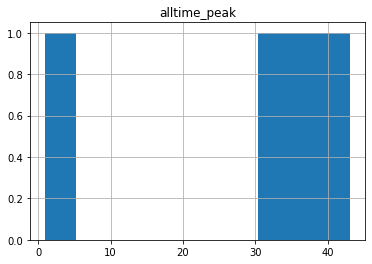

In [127]:
one_hit[one_hit['primary_artist']=='Laura Branigan'].hist()

In [16]:
# sort values by start date and position
charts.sort_values(['start_date', 'position'], inplace=True, ignore_index=True)

In [17]:
charts.head(10)

artist                       song label  position start_date  \
0            ABBA        Money, Money, Money               1 1977-01-03   
1    David Dundas                   Jeans On               2 1977-01-03   
2        Boney M.                      Sunny               3 1977-01-03   
3        Boney M.                 Daddy Cool               4 1977-01-03   
4         Chicago        If You Leave Me Now               5 1977-01-03   
5  Costa Cordalis                      Anita               6 1977-01-03   
6      Ricky King                      Verde               7 1977-01-03   
7          Smokie  Living Next Door To Alice               8 1977-01-03   
8   Tina Rainford                Silver Bird               9 1977-01-03   
9  Johnny Wakelin                   In Zaire              10 1977-01-03   

    end_date  week  year decade                         artist_song  \
0 1977-01-09     1  1977  1970s          ABBA - Money, Money, Money   
1 1977-01-09     1  1977  1970s             David Dundas - Jeans On   
2 1977-01-09     1  1977  1970s                    Boney M. - Sunny   
3 1977-01-09     1  1977  1970s               Boney M. - Daddy Cool   
4 1977-01-09     1  1977  1970s       Chicago - If You Leave Me Now   
5 1977-01-09     1  1977  1970s              Costa Cordalis - Anita   
6 1977-01-09     1  1977  1970s                  Ricky King - Verde   
7 1977-01-09     1  1977  1970s  Smokie - Living Next Door To Alice   
8 1977-01-09     1  1977  1970s         Tina Rainford - Silver Bird   
9 1977-01-09     1  1977  1970s           Johnny Wakelin - In Zaire   

   primary_artist feature_artist  alltime_peak  yearly_peak  top10  
0            ABBA           None             1            1    1.0  
1    David Dundas           None             2            2    1.0  
2        Boney M.           None             1            1    1.0  
3        Boney M.           None             4            4    1.0  
4         Chicago           None             3            3    1.0  
5  Costa Cordalis           None             3            3    1.0  
6      Ricky King           None             7            7    1.0  
7          Smokie           None             1            1    1.0  
8   Tina Rainford           None             6            6    1.0  
9  Johnny Wakelin           None            10           10    1.0

## Top Artists

In [18]:
# Number of times an artist appears in the charts for the year
counts = charts['artist'].value_counts().rename_axis('artist').reset_index(name='counts')


# Limit number of artists to the ones appearing more than 250 times
top_artists = counts[counts['counts'] >= 250]

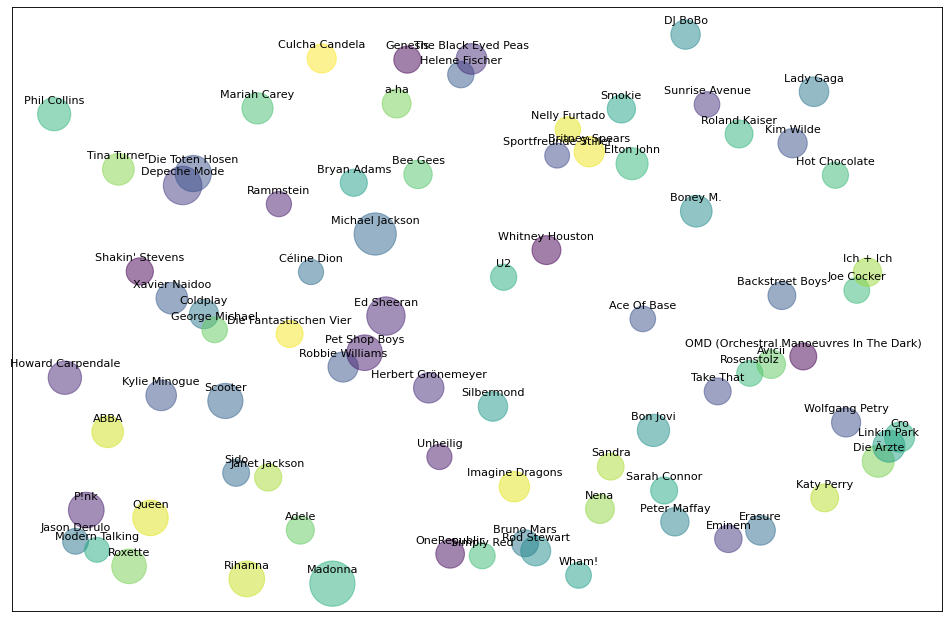

In [19]:
#Draw plot
plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

top_artists = top_artists.sample(frac=1)       # randomize position on the x-axis

x = top_artists['artist']
y = np.random.rand(len(x))                     # randomize position on the y-axis
colors = np.random.rand(len(x))                # randomize colors

plt.scatter(x, y,
            marker='o',
            s=top_artists['counts']*2,        # marker size depends on the number of times artist appears
            alpha=0.5,
            c=colors)


# Label points with artist name, called for each point
for i,j in zip(x,y):
    label = i
    plt.annotate(label,                        # this is the text
                 (i,j),                        # this is the point to label
                 textcoords="offset points",   # how to position the text
                 xytext=(0,10),                # distance from text to points (x,y)
                 ha='center')                  # horizontal alignment can be left, right or center

plt.xticks([], [])
plt.yticks([], [])

plt.show()

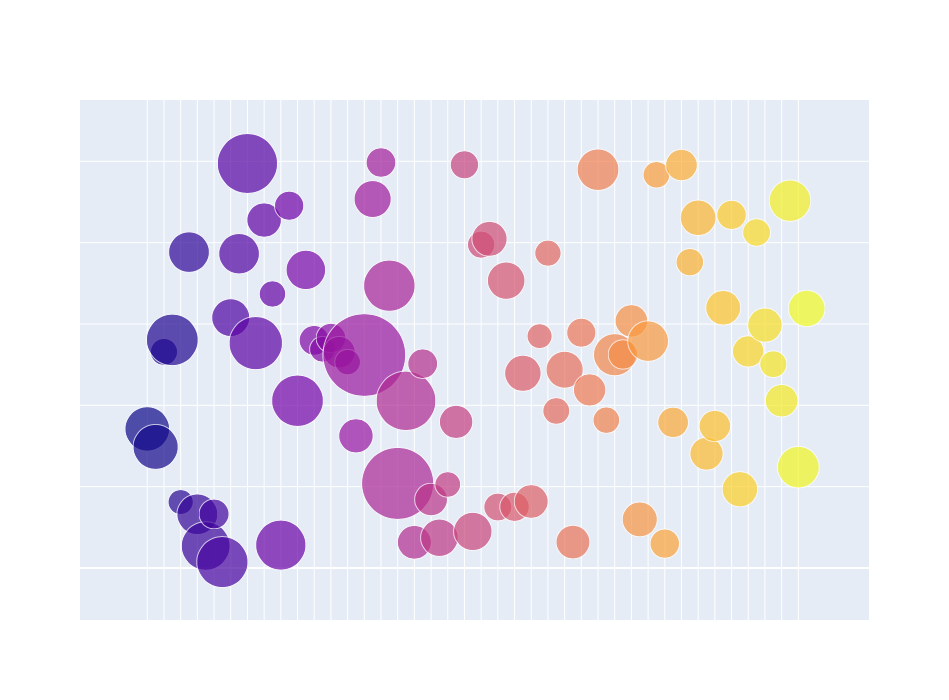

In [20]:
import plotly.graph_objects as go

c = list(range(len(x)))

fig = go.Figure(data=go.Scatter(
    x=top_artists['artist'],
    y=np.random.rand(len(x)),
    mode='markers',
    marker=dict(size=top_artists['counts']/10,
                color=c),
    hovertext=top_artists['artist'],
    hoverinfo="text"
))

fig.update_layout(
    xaxis = dict(showticklabels=False),
    yaxis = dict(showticklabels=False),
    width=1000,
    height=700
)

fig.show()

## Songs by Artist

In [49]:
# Function to see development of all songs by one artist during the year

def info_artist(artist_name):
    # Filter dataframe by requested artist
    df = charts[charts['primary_artist']==artist_name].sort_values(by='start_date').copy()  #also includes features
    # Select all songs by artist
    tracks = df.song.unique()
    
    plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    
    # Draw plot for each track
    for track in tracks:
        x = df[df['song'] == track]['start_date']
        y = df[df['song'] == track]['position']
        plt.scatter(x, y,
                    marker='o',
                    s=1000-y*10,   # marker size depends on the position of the track in the charts
                    alpha=.5,
                    label=track)

    plt.yticks(np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    plt.title('Information for {}'.format(df['primary_artist'].unique()))
    plt.legend(numpoints=1)

    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()

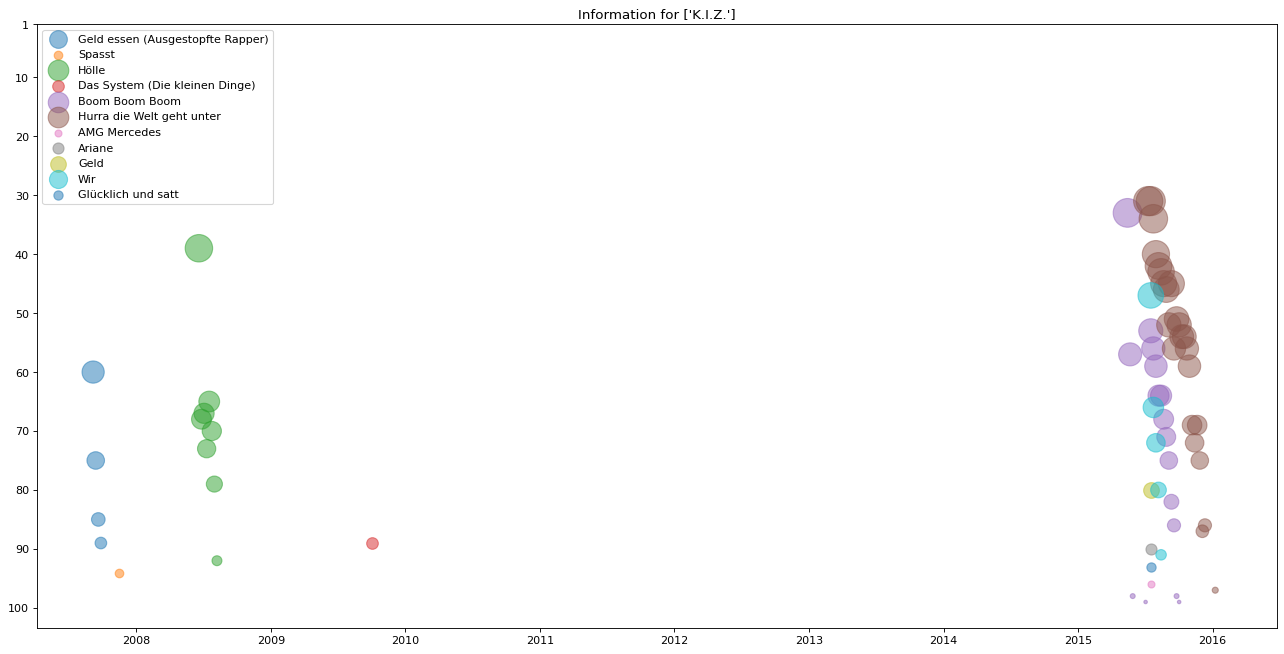

In [52]:
# Example
info_artist("K.I.Z.")

## No.1 Songs

#### No.1 Songs during Period

In [23]:
def info_no1(start_year=2019, end_year=2020):
    # find No.1 songs of the particular year
    df = charts[(charts['year'] >= start_year) & (charts['year'] <= end_year)]
    
    # all songs that were at least one week No.1
    ones = df['yearly_peak'] == 1
    ones_other = df[ones].sort_values(['position', 'start_date'])
    
    # songs at the moment they were No.1
    peak_position = df['position'] == 1
    peaks = df[peak_position]
    
    # Determine limits for x-axis
    min_date = ones_other.start_date.min()
    max_date = ones_other.end_date.max()
    
    # Determine required size of graph
    w = 20
    l = ones_other['artist_song'].nunique() / 2

    # Draw plot
    fig, ax = plt.subplots(figsize=(w,l), dpi= 80)
    ax.hlines(y=ones_other['artist_song'], xmin=min_date, xmax=max_date, color='gray', alpha=0.3, linewidth=0.5, linestyles='dashdot')
    ax.scatter(y=peaks['artist_song'], x=peaks['start_date'], color='#0e668b', s=75)
    ax.scatter(y=ones_other['artist_song'], x=ones_other['start_date'], s=75, color='#a3c4dc', alpha=0.3)

    # Title
    ax.set_title('No.1 songs between {} and {}'.format(start_year, end_year), fontdict={'size':30})
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.show()

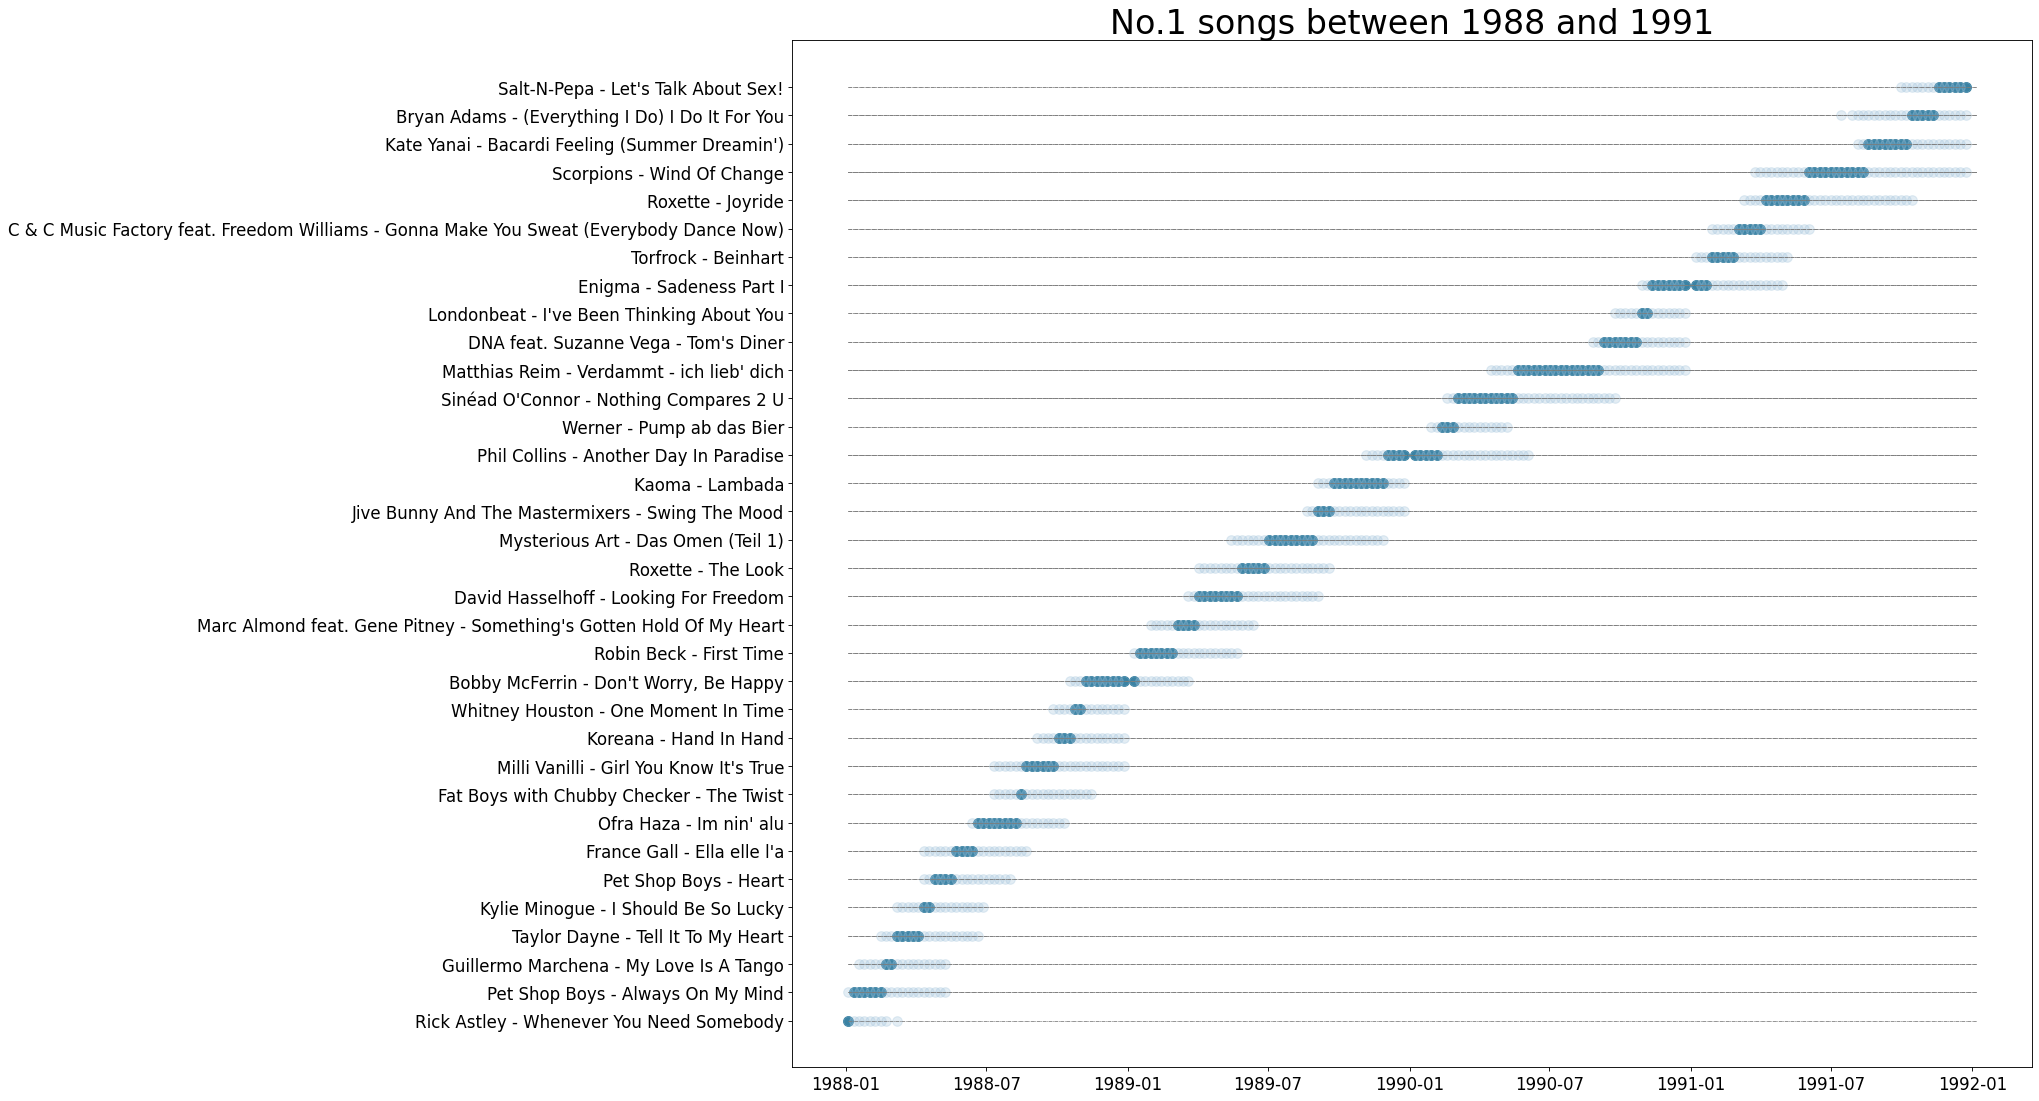

In [24]:
info_no1(1988, 1991)

#### No.1 weeks in charts

In [25]:
def weeks_in_charts(start_year=2019, end_year=2019):
    # find No.1 songs of the particular year
    df = charts[(charts['year'] >= start_year) & (charts['year'] <= end_year)]
    
    # all songs that were at least one week No.1
    ones = df['yearly_peak'] == 1
    
    # songs at the moment they were No.1
    peak_position = df['position'] == 1
    
    # Number of weeks song was in Top100
    weeks_top100 = df[ones].groupby(['artist_song'], as_index=False).count()[['artist_song', 'week']]

    # Number of weeks song was on No.1
    weeks_no1 = df[peak_position].groupby(['artist_song'], as_index=False).count()[['artist_song', 'week']]

    # Create dataframe
    weeks = weeks_top100.merge(weeks_no1, how='left', on='artist_song')
    weeks.columns = ['artist_song', 'weeks_in_charts', 'weeks_on_one']
    weeks.sort_values(by=['weeks_in_charts'], inplace=True)
    
    # Determine required size of graph
    w = 20
    l = len(weeks) / 4
    
    # Draw plot
    fig, ax = plt.subplots(1,1,figsize=(w,l), facecolor='#f7f7f7', dpi= 80)

    # Plot weeks in charts
    plt.hlines(y=weeks['artist_song'], xmin=0, xmax=weeks['weeks_in_charts'], color='#a3c4dc')
    plt.plot(weeks['weeks_in_charts'], weeks['artist_song'], ">", color='#0e668b')

    # Plot weeks on 1
    plt.hlines(y=weeks['artist_song'], xmin=0, xmax=weeks['weeks_on_one'], color='#dcbba3')
    plt.plot(weeks['weeks_on_one'], weeks['artist_song'], ">", color='#8b330e')

    ax.set_facecolor('#f7f7f7')
    ax.set_xlabel('weeks in charts', fontsize=10)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=10)
    plt.figtext(0.75, 0.15, "red:  weeks on No.1\nblue: weeks in Top 100", ha="left", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.show()

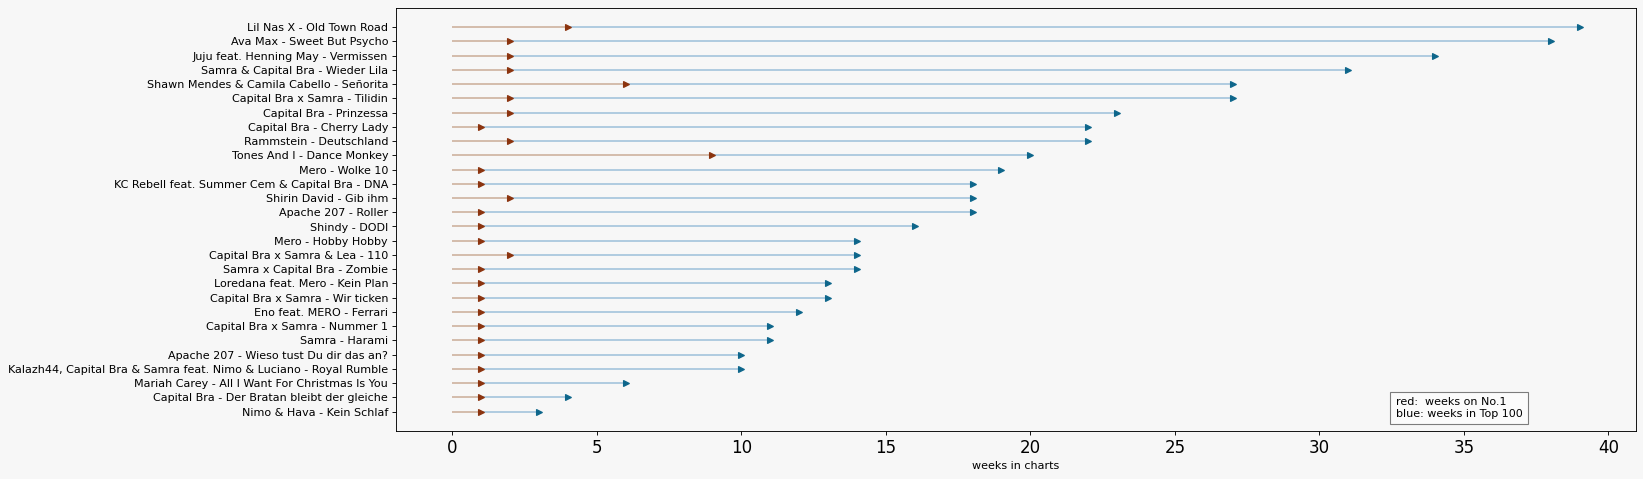

In [63]:
weeks_in_charts(2019, 2020)

## Song Titles

In [27]:
import itertools
import collections
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [28]:
# removing special characters
special_characters = ['!', '?', '#', '/', '(', ')', '&', '%', '$', '*', '+']
title = charts.song

for char in special_characters:
    title = title.str.replace(char, '')

In [29]:
# extract words from song titles
#words_in_title = [song.lower().split() for song in title.unique()]     # for words in unique titles
words_in_title = [song.lower().split() for song in title]               # for words in titles depending appearance in charts
words_in_title[:5]

[['money,', 'money,', 'money'],
 ['jeans', 'on'],
 ['sunny'],
 ['daddy', 'cool'],
 ['if', 'you', 'leave', 'me', 'now']]

In [30]:
# List of all words across title
all_words = list(itertools.chain(*words_in_title))

# Create counter
count_words = collections.Counter(all_words)

# Remove stopwords
stop_words = STOPWORDS

# Add Christmas to stopword
stop_words.update(['christmas', 'ich', 'du', 'er', 'sie', 'es', 'wir', 'ihr', 'der', 'die', 'das', 'mich', 'dich', \
                   'uns', 'ist', 'ein', 'nicht', 'man', 'von', 'da', 'mit', 'dir', 'im', 'den', 'dem', 'mir', 'bist', \
                   'wie', 'zu', 'aus', 'bin', 'auf', 'mein', 'und'])

titles_nsw = [[word for word in title_words if not word in stop_words]
              for title_words in words_in_title]

all_words = list(itertools.chain(*titles_nsw))

# count word without stopword
counts_nsw = collections.Counter(all_words)

# Top ten most used words
counts_nsw.most_common(10)

[('love', 10601),
 ('one', 2299),
 ('heart', 2116),
 ('time', 1941),
 ('life', 1880),
 ('la', 1880),
 ('go', 1858),
 ('night', 1858),
 ('girl', 1587),
 ('world', 1544)]

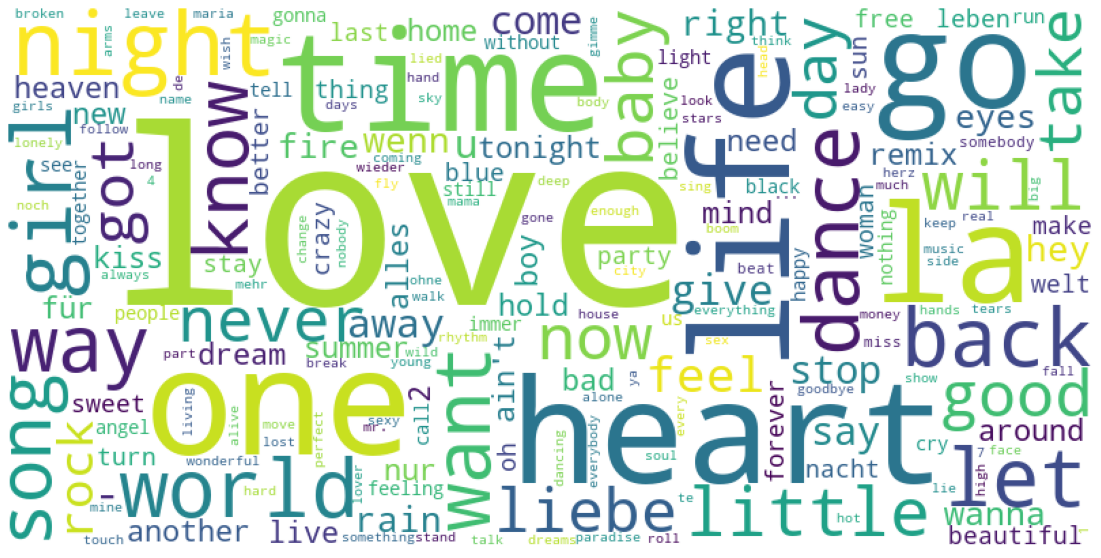

In [31]:
# Create and generate a word cloud image:
wordcloud = WordCloud(
                max_font_size=180,
                max_words=200,
                stopwords=stop_words,
                background_color="white",
                width=800,
                height=400
                ).fit_words(counts_nsw)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Uncomment to save image
#plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

# Save the image in the img folder:
#wordcloud.to_file("2019_titles.png")

In [32]:
#charts[charts['song'].str.contains('Christmas')].groupby(['song']).max().sort_values(by='position', ascending=True)

## Artists

In [33]:
charts.head()

artist                 song label  position start_date   end_date  \
0          ABBA  Money, Money, Money               1 1977-01-03 1977-01-09   
1  David Dundas             Jeans On               2 1977-01-03 1977-01-09   
2      Boney M.                Sunny               3 1977-01-03 1977-01-09   
3      Boney M.           Daddy Cool               4 1977-01-03 1977-01-09   
4       Chicago  If You Leave Me Now               5 1977-01-03 1977-01-09   

   week  year decade                    artist_song primary_artist  \
0     1  1977  1970s     ABBA - Money, Money, Money           ABBA   
1     1  1977  1970s        David Dundas - Jeans On   David Dundas   
2     1  1977  1970s               Boney M. - Sunny       Boney M.   
3     1  1977  1970s          Boney M. - Daddy Cool       Boney M.   
4     1  1977  1970s  Chicago - If You Leave Me Now        Chicago   

  feature_artist  alltime_peak  yearly_peak  top10  
0           None             1            1    1.0  
1           None             2            2    1.0  
2           None             1            1    1.0  
3           None             4            4    1.0  
4           None             3            3    1.0

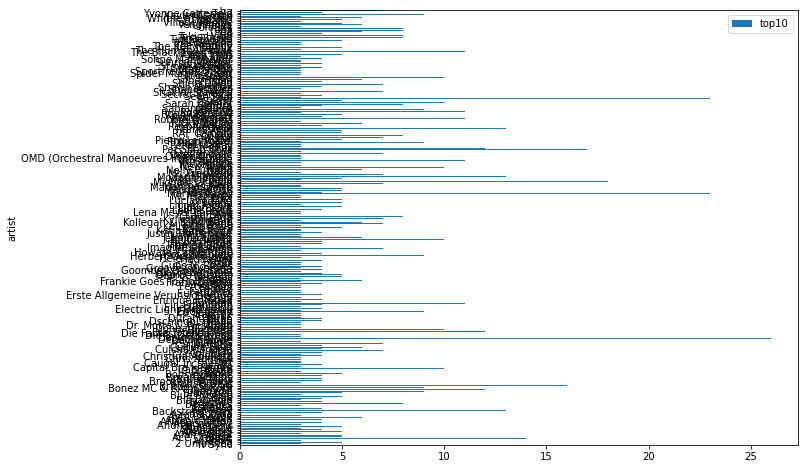

In [34]:
top10 = charts[charts['top10'] == 1]
top10_artist = top10.groupby(['artist', 'song']).count().groupby(['artist']).count()[['top10']]
top10_artist[top10_artist['top10']>=3].plot(kind='barh', figsize=(10, 8))

In [35]:
charts['artist_song'].nunique()

19405

In [62]:
import pickle

songs = list(set(charts['artist_song'].tolist()))

with open('song_list.data','wb') as f:
    pickle.dump(songs, f)

In [66]:
charts[charts['artist'].str.contains('feat.')]

artist  \
2830                      Eruption feat. Precious Wilson   
2880                      Eruption feat. Precious Wilson   
2919                      Eruption feat. Precious Wilson   
2966                      Eruption feat. Precious Wilson   
3016                      Eruption feat. Precious Wilson   
...                                                  ...   
201896                             Sido feat. Apache 207   
201897                            Juju feat. Henning May   
201902                 Riton x Oliver Heldens feat. Vula   
201933                  Gwen Stefani feat. Blake Shelton   
201948  The Kingdom Choir feat. Camélia Jordana & Namika   

                                   song              label  position  \
2830             I Can't Stand The Rain         Hansa Int.        31   
2880             I Can't Stand The Rain         Hansa Int.        31   
2919             I Can't Stand The Rain         Hansa Int.        20   
2966             I Can't Stand The Rain         Hansa Int.        17   
3016             I Can't Stand The Rain         Hansa Int.        17   
...                                 ...                ...       ...   
201896                             2002              Urban        47   
201897                        Vermissen         Jinx Music        48   
201902                       Turn Me On  Ministry Of Sound        53   
201933  You Make It Feel Like Christmas         Interscope        84   
201948              Holidays Are Coming   SME - Sony Music        99   

       start_date   end_date  week  year decade  \
2830   1978-01-30 1978-02-05     5  1978  1970s   
2880   1978-02-06 1978-02-12     6  1978  1970s   
2919   1978-02-13 1978-02-19     7  1978  1970s   
2966   1978-02-20 1978-02-26     8  1978  1970s   
3016   1978-02-27 1978-03-05     9  1978  1970s   
...           ...        ...   ...   ...    ...   
201896 2019-12-27 2020-01-02    52  2019  2010s   
201897 2019-12-27 2020-01-02    52  2019  2010s   
201902 2019-12-27 2020-01-02    52  2019  2010s   
201933 2019-12-27 2020-01-02    52  2019  2010s   
201948 2019-12-27 2020-01-02    52  2019  2010s   

                                              artist_song     primary_artist  \
2830    Eruption feat. Precious Wilson - I Can't Stand...           Eruption   
2880    Eruption feat. Precious Wilson - I Can't Stand...           Eruption   
2919    Eruption feat. Precious Wilson - I Can't Stand...           Eruption   
2966    Eruption feat. Precious Wilson - I Can't Stand...           Eruption   
3016    Eruption feat. Precious Wilson - I Can't Stand...           Eruption   
...                                                   ...                ...   
201896                       Sido feat. Apache 207 - 2002               Sido   
201897                 Juju feat. Henning May - Vermissen               Juju   
201902     Riton x Oliver Heldens feat. Vula - Turn Me On              Riton   
201933  Gwen Stefani feat. Blake Shelton - You Make It...       Gwen Stefani   
201948  The Kingdom Choir feat. Camélia Jordana & Nami...  The Kingdom Choir   

                  feature_artist  alltime_peak  yearly_peak  top10  
2830             Precious Wilson             7            7    1.0  
2880             Precious Wilson             7            7    1.0  
2919             Precious Wilson             7            7    1.0  
2966             Precious Wilson             7            7    1.0  
3016             Precious Wilson             7            7    1.0  
...                          ...           ...          ...    ...  
201896                Apache 207             6            6    1.0  
201897               Henning May             1            1    1.0  
201902            Oliver Heldens            32           32    0.0  
201933             Blake Shelton            53           84    0.0  
201948  Camélia Jordana & Namika            99           99    0.0  

[23672 rows x 15 columns]